In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense , Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping , LearningRateScheduler
import keras.backend as K
from keras.initializers import lecun_uniform
from keras import metrics , regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


Using TensorFlow backend.


In [22]:
def splitData(X,Y,rate):
    X_train = X[:int(X.shape[0]*rate)]
    Y_train = Y[:int(Y.shape[0]*rate)]
    X_val = X[int(X.shape[0]*rate):]
    Y_val = Y[int(Y.shape[0]*rate)-1:]
    return X_train, Y_train, X_val, Y_val

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def metric_R2(y_true,y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 20.0
    lrate = initial_lrate * np.power(drop,np.floor((1+epoch)/epochs_drop))
    return lrate    

df = pd.read_csv("data/2330_indicators.csv").drop(['date'],axis=1)
X_train = df[:-1].values

y_train = df.loc[1:,['closed']].values
X_train , Y_train , X_val , Y_val = splitData(X_train,y_train,0.8)
ta,ta,tc,td = splitData(X_train,y_train,0.8)
print(X_val.shape,Y_val.shape)

(1249, 9) (1250, 1)


In [23]:
sc_X = MinMaxScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_val_sc = sc_X.transform(X_val)
sc_Y = MinMaxScaler()
Y_train_sc = sc_Y.fit_transform(Y_train)
Y_val_sc = sc_Y.transform(Y_val)

In [24]:
X_train_steps = []
Y_train_steps = []
for i in range(20, len(X_train_sc)):  # 1258 是訓練集總數
    X_train_steps.append(X_train_sc[i-20:i])
    Y_train_steps.append(Y_train_sc[i])
X_train, Y_train = np.array(X_train_steps), np.array(Y_train_steps)

X_val_steps = []
Y_val_steps = []
for i in range(20,len(X_val_sc)):
    X_val_steps.append(X_val_sc[i-20:i])
    Y_val_steps.append(Y_val_sc[i])
X_val , Y_val = np.array(X_val_steps) , np.array(Y_val_steps)


In [5]:
epochs = 300
batch_size = 32
LSTM_num = 3
units = 16

model_lstm = Sequential()
#use L2 to improve overfit
model_lstm.add(LSTM(units,input_shape=X_train.shape[1:],activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.0009),return_sequences=True)) 

model_lstm.add(LSTM(units,kernel_regularizer=regularizers.l2(0.0009),return_sequences=True))

model_lstm.add(LSTM(units,kernel_regularizer=regularizers.l2(0.0009),return_sequences=False))

model_lstm.add(Dense(1))
model_lstm.summary()
model_lstm.compile(loss='mean_squared_error',optimizer="Adam",metrics=[rmse])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 16)            1664      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 5,905
Trainable params: 5,905
Non-trainable params: 0
_________________________________________________________________


In [6]:
#decay lr by half every 10 epoch
lrate = LearningRateScheduler(step_decay)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=1)
history = model_lstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, shuffle=False,validation_data=(X_val,Y_val),callbacks=[early_stop])
y_pred_test_lstm = model_lstm.predict(X_val)
y_train_pred_lstm = model_lstm.predict(X_train)
r2score = r2_score(Y_val, y_pred_test_lstm)
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))

Train on 4973 samples, validate on 1229 samples
Epoch 1/300
4973/4973 [==============================] - 20s 4ms/step - loss: 0.1245 - rmse: 0.1129 - val_loss: 0.1596 - val_rmse: 0.2309
Epoch 2/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0740 - rmse: 0.0646 - val_loss: 0.0739 - val_rmse: 0.0944
Epoch 3/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0539 - rmse: 0.0408 - val_loss: 0.0565 - val_rmse: 0.0880
Epoch 4/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0435 - rmse: 0.0373 - val_loss: 0.0505 - val_rmse: 0.0824
Epoch 5/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0372 - rmse: 0.0372 - val_loss: 0.0492 - val_rmse: 0.0925
Epoch 6/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0338 - rmse: 0.0430 - val_loss: 0.0406 - val_rmse: 0.0803
Epoch 7/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0297 - rmse: 0.0400 - val_loss: 0.0306 - val

4973/4973 [==============================] - 16s 3ms/step - loss: 0.0035 - rmse: 0.0284 - val_loss: 0.0045 - val_rmse: 0.0409
Epoch 60/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0034 - rmse: 0.0284 - val_loss: 0.0040 - val_rmse: 0.0384
Epoch 61/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0034 - rmse: 0.0283 - val_loss: 0.0041 - val_rmse: 0.0387
Epoch 62/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0034 - rmse: 0.0282 - val_loss: 0.0041 - val_rmse: 0.0392
Epoch 63/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0034 - rmse: 0.0282 - val_loss: 0.0041 - val_rmse: 0.0391
Epoch 64/300
4973/4973 [==============================] - 17s 3ms/step - loss: 0.0033 - rmse: 0.0282 - val_loss: 0.0041 - val_rmse: 0.0390
Epoch 65/300
4973/4973 [==============================] - 16s 3ms/step - loss: 0.0033 - rmse: 0.0281 - val_loss: 0.0039 - val_rmse: 0.0381
Epoch 66/300
4973/4973 [================

FileNotFoundError: [Errno 2] No such file or directory: 'pltfigs/LSTM_layers3_units16_epochs300_batch_size32_r2score~0.951.png'

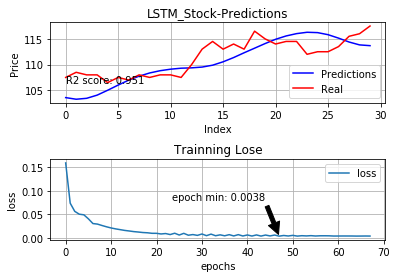

In [7]:
val_loss = history.history['val_loss']

plt.figure(1)
plt.subplot(211)
plt.plot(sc_Y.inverse_transform(y_pred_test_lstm[:30]),'b',label='Predictions')
plt.plot(sc_Y.inverse_transform(Y_val[:30]),'r',label='Real')
plt.title('LSTM_Stock-Predictions',)
plt.xlabel('Index')
plt.ylabel('Price')
score = "{:0.3f}".format(r2score)
plt.text(0,plt.ylim()[1]*0.9,'R2 score: '+ score)
plt.legend(loc='lower right')


plt.grid(True)


plt.subplot(212)
plt.title("Trainning Lose")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(val_loss,label='loss')
plt.legend(loc='upper right')
notate_xy = [np.argmin(val_loss),np.min(val_loss)]
plt.annotate('epoch min: {:0.4f}'.format(notate_xy[1]), xy=notate_xy, xytext=(np.argmin(val_loss)*0.5, np.max(val_loss)*0.5),arrowprops=dict(facecolor='black', shrink=0.05),)
plt.grid(True)
plt.subplots_adjust(hspace=0.7)
saveName = 'LSTM_layers'+str(LSTM_num)+'_units'+str(units)+'_epochs'+str(epochs)+'_batch_size'+str(batch_size)+'_r2score~'+str(score)
plt.savefig('pltfigs/'+saveName+'.png',dpi=200)
plt.show()

In [ ]:
model_lstm.save(saveName+'.h5')

In [ ]:
def rmse(val , pred):
    return np.mean(np.divide(pred,val))
print(str(rmse(Y_val,y_pred_test_lstm)))

In [54]:
a = sc_Y.inverse_transform(y_pred_test_lstm)
b = sc_Y.inverse_transform(Y_val)
def unperiods(data,days=20):
    l = []
    for a in data:
        l.extend(a)
    return l

print(np.mean(np.abs(a-b)/b)*100)
a = unperiods(a)
b = unperiods(b)
print(X_val.shape)

3.6226495041592024
(1229, 20, 9)


In [47]:
prices= tc
#sr: spread rate
def ROR(preds,real,init_funds,period,sr=0.004,s=False):
    dict_Info = {
        'total_costs':[],
        'total_prices':[],
        'trade_times':[],
        'verbose':[],
        "RORs":[]
    }
    funds = init_funds
    profit=0
    total_cost=0
    total_price=0
    acc = []
    times = 0
    verbose = ''
    for i,p in enumerate(real):
        #print(dates_val[i],prices[i][0],preds[i],p,p-prices[i][0])
        if preds[i]>prices[i][0] and (abs(preds[i]-prices[i][0])/prices[i][0]) > sr:
            times +=1
            quantity = int(funds / preds[i])
            total_cost += prices[i][0] * quantity
            total_price += p * quantity
            funds += (p-prices[i][0]) * quantity
            #verbose += "\nBuy Date: {} - {}\nPrediction: {}\nReal Price: {}\nSpread: {}\n".format(dates_val[i],prices[i][0],preds[i],p,p-prices[i][0])
        if (i+1)%period==0:
            #pass and not record the rate of prediciotn 'pre' < rate of threshold 'r'
            if total_cost != 0:
                dict_Info['total_costs'].append(total_cost*1000)
                dict_Info['total_prices'].append(total_price*1000)
                dict_Info['trade_times'].append(times)
                dict_Info['verbose'].append(verbose)
                dict_Info['RORs'].append((funds)/init_funds)
            times=0
            funds = init_funds
            total_cost=0
            total_price=0
            verbose = ''
    if times!=0:
        dict_Info['total_costs'].append(total_cost*1000)
        dict_Info['total_prices'].append(total_price*1000)
        dict_Info['trade_times'].append(times)
        dict_Info['verbose'].append(verbose)
        dict_Info['RORs'].append((funds)/init_funds*0.99575)
    return dict_Info,init_funds

In [48]:
d,funds = ROR(a,b,1000,20*12)
for i in range(len(d['total_prices'])):
    msg = 'Total Costs: {}\nInitial Funds: {}\nProfits: {}\nReturn Of Rate: {}\n'.format(d['total_costs'][i],
                                                                                     d['trade_times'][i],
                                                                                    funds*1000,
                                                                                     (d['total_prices'][i]-d['total_costs'][i])*0.99575,
                                                                                     d['RORs'][i])
    #print(d['verbose'][i])
    print(msg)
print("Average of Months ROR: {:.3f}".format(np.mean(d['RORs'])))

IndexError: index 999 is out of bounds for axis 0 with size 999